In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir(r"/content/drive/MyDrive")
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive'

In [3]:
import glob
import random
import numpy as np
import pandas as pd
import time
import os
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.preprocessing import LabelEncoder
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torchvision
from torchvision import transforms, datasets, models
from torch import optim, cuda
from timeit import default_timer as timer
import torch
import torch.nn as nn

In [4]:
TRAIN_FOLDER = '/content/drive/MyDrive/Atividade/ImageClef-2019-VQA-Med-Full/ImageClef-2019-VQA-Med-Full/ImageClef-2019-VQA-Med-Training/ImageClef-2019-VQA-Med-Training/Train_images'
VAL_FOLDER = '/content/drive/MyDrive/Atividade/ImageClef-2019-VQA-Med-Full/ImageClef-2019-VQA-Med-Full/ImageClef-2019-VQA-Med-Validation/ImageClef-2019-VQA-Med-Validation/Val_images'

In [5]:
path = '/content/drive/MyDrive/Atividade/ImageClef-2019-VQA-Med-Full/ImageClef-2019-VQA-Med-Full/ImageClef-2019-VQA-Med-Training/ImageClef-2019-VQA-Med-Training/QAPairsByCategory'

filenames = glob.glob(path + "/*.txt")

dfs = []

for filename in filenames:
    category = filename.split('/')[-1].replace('_train.txt','')
    df_temp = pd.read_csv(filename, delimiter='|', names=['id','question','answer'])
    dfs.append(df_temp)

df_train = pd.concat(dfs, ignore_index=True)

In [6]:
df_train

,id,question,answer
0,synpic41148,which organ is captured by this ct scan?,"lung, mediastinum, pleura"
1,synpic43984,what organ system is primarily present in this...,skull and contents
2,synpic38930,which organ system is imaged?,genitourinary
3,synpic52143,the mri shows what organ system?,spine and contents
4,synpic20934,what organ system is shown in this x-ray?,spine and contents
...,...,...,...
9595,synpic35685,in what plane is this mri?,sagittal
9596,synpic35687,which plane is this image in?,sagittal
9597,synpic35701,what is the plane of the image?,sagittal
9598,synpic48036,what imaging plane is depicted here?,axial


In [7]:
path = r'/content/drive/MyDrive/Atividade/ImageClef-2019-VQA-Med-Full/ImageClef-2019-VQA-Med-Full/ImageClef-2019-VQA-Med-Validation/ImageClef-2019-VQA-Med-Validation/QAPairsByCategory'

filenames = glob.glob(path + "/*.txt")

dfs = []

# Iterate through each file
for filename in filenames:
    category = filename.split('/')[-1].replace('_train.txt','')
    df_temp = pd.read_csv(filename, delimiter='|', names=['id','question','answer'])
    dfs.append(df_temp)

df_valid = pd.concat(dfs, ignore_index=True)

In [8]:
df_valid

,id,question,answer
0,synpic54733,in what plane is this image oriented?,axial
1,synpic25647,what plane is this x-ray in?,ap
2,synpic35681,what plane is demonstrated?,coronal
3,synpic39641,in what plane was this image taken?,axial
4,synpic35693,in what plane is this mri taken?,sagittal
...,...,...,...
1995,synpic45828,is this a noncontrast mri?,yes
1996,synpic60458,what type of imaging is this?,xr - plain film
1997,synpic43524,is \tthis a t1 weighted image?,yes
1998,synpic59568,"is this a t1 weighted, t2 weighted, or flair i...",flair


In [9]:
temp_df = pd.concat([df_train, df_valid])
unique_answers = temp_df['answer'].unique()
answer_to_index = {answer: idx for idx, answer in enumerate(unique_answers)}
index_to_answer = {idx: answer for idx, answer in enumerate(unique_answers)}
num_answers = len(unique_answers)
num_answers

482

In [24]:
index_to_answer[22]

't1'

In [11]:
unique_answers

array(['lung, mediastinum, pleura', 'skull and contents', 'genitourinary',
       'spine and contents', 'musculoskeletal', 'heart and great vessels',
       'vascular and lymphatic', 'gastrointestinal',
       'face, sinuses, and neck', 'breast', 'cta - ct angiography', 'no',
       'us - ultrasound', 'xr - plain film', 'noncontrast', 'yes', 't2',
       'ct w/contrast (iv)', 'mr - flair', 'mammograph',
       'ct with iv contrast', 'gi and iv', 't1', 'mr - t2 weighted',
       'mr - t1w w/gadolinium', 'contrast', 'iv', 'an - angiogram',
       'mra - mr angiography/venography', 'nm - nuclear medicine',
       'mr - dwi diffusion weighted', 'ct - gi & iv contrast',
       'ct noncontrast', 'mr - other pulse seq.',
       'ct with gi and iv contrast', 'flair',
       'mr - t1w w/gd (fat suppressed)', 'ugi - upper gi',
       'mr - adc map (app diff coeff)', 'bas - barium swallow',
       'pet - positron emission', 'mr - pdw proton density',
       'mr - t1w - noncontrast', 'be - barium 

In [12]:
# Load ResNet50 models
def load_resnet_model(model_path, num_classes):
    model = models.resnet50(pretrained=False)
    n_inputs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(n_inputs, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, num_classes),
        nn.LogSoftmax(dim=1)
    )
    model.load_state_dict(torch.load(model_path))
    return model

In [13]:
# Define the MedicalVQADataset class
class MedicalVQADataset(Dataset):
    def __init__(self, dataframe, image_dir, tokenizer, transform=None, answer_to_index=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.transform = transform
        self.answer_to_index = answer_to_index

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_id = row['id']
        question = row['question']
        answer = row['answer']

        # Load image
        image_path = os.path.join(self.image_dir, f"{image_id}.jpg")
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Tokenize question
        inputs = self.tokenizer(question, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        # Encode the answer as an index
        answer_index = answer_to_index[answer]

        return image, input_ids, attention_mask, answer_index



organ_model = load_resnet_model('/content/drive/MyDrive/Atividade/organ-resnet50.pt', num_classes=10)
plane_model = load_resnet_model('/content/drive/MyDrive/Atividade/plane-resnet.pt', num_classes=15)

# Modify ResNet models to output features directly
model1 = nn.Sequential(*list(organ_model.children())[:-1], nn.Flatten())
model2 = nn.Sequential(*list(plane_model.children())[:-1], nn.Flatten())

# Tokenizer
bert_pretrained_path = '/content/drive/MyDrive/Atividade/ImageClef-2019-VQA-Med-Full/ImageClef-2019-VQA-Med-Full/model_save'
tokenizer = BertTokenizer.from_pretrained(bert_pretrained_path)

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets
train_dataset = MedicalVQADataset(df_train, TRAIN_FOLDER, tokenizer, transform)
valid_dataset = MedicalVQADataset(df_valid, VAL_FOLDER, tokenizer, transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [14]:
import torch.nn.functional as F

In [15]:
class DualImageFeatureExtractor(nn.Module):
    def __init__(self, model1, model2, image_feature_dim1, image_feature_dim2, fusion_dim):
        super(DualImageFeatureExtractor, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.fusion_layer = nn.Linear(image_feature_dim1 + image_feature_dim2, fusion_dim)

    def forward(self, images):
        batch_size = images.size(0)
        features1 = self.model1(images).view(batch_size, -1)  # Flatten if needed
        features2 = self.model2(images).view(batch_size, -1)  # Flatten if needed

        concatenated_features = torch.cat((features1, features2), dim=1)

        fused_features = self.fusion_layer(concatenated_features)
        return fused_features



class DualVQAModel(nn.Module):
    def __init__(self, image_feature_dim1, image_feature_dim2, question_feature_dim, hidden_dim, vocab_size, embedding_dim, num_answers, fusion_dim, num_heads):
        super(DualVQAModel, self).__init__()
        self.image_extractor = DualImageFeatureExtractor(model1, model2, image_feature_dim1, image_feature_dim2, fusion_dim)
        self.question_encoder = BertModel.from_pretrained(bert_pretrained_path)

        self.attention = nn.MultiheadAttention(embed_dim=fusion_dim + question_feature_dim, num_heads=num_heads)
        self.fc1 = nn.Linear(fusion_dim + question_feature_dim, hidden_dim)
        self.dropout = nn.Dropout(p=0.3)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_answers)

    def forward(self, images, input_ids, attention_mask):
        image_features = self.image_extractor(images)
        question_features = self.question_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]  # Get [CLS] token
        combined_features = torch.cat((image_features, question_features), dim=1)

        attn_output, _ = self.attention(combined_features.unsqueeze(1), combined_features.unsqueeze(1), combined_features.unsqueeze(1))
        attn_output = attn_output.squeeze(1)  # Remove the batch dimension

        # Apply skip connection, dropout, and normalization
        x = attn_output + combined_features  # Skip connection
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.layer_norm(x)
        x = self.fc2(x)
        return x


In [ ]:
# Define hyperparameters
image_feature_dim1 = 2048  # Dimension of model1's features
image_feature_dim2 = 2048  # Dimension of model2's features
question_feature_dim = 768  # Dimension of BERT's output features
hidden_dim = 512  # Dimension of the hidden layer
vocab_size = tokenizer.vocab_size  # Vocabulary size from BERT tokenizer
embedding_dim = 768  # BERT embedding dimension
num_answers = 1000  # Number of possible answers (this is an example)
fusion_dim = 1024  # Dimension of fused image features
num_heads = 8

# Instantiate the dual VQA model
dual_model = DualVQAModel(image_feature_dim1, image_feature_dim2, question_feature_dim, hidden_dim, vocab_size, embedding_dim, num_answers, fusion_dim, num_heads)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dual_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dual_model.parameters(), lr=1e-4)

# Early stopping parameters
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    dual_model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for images, input_ids, attention_mask, answers in train_loader:
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        answers = answers.to(device)

        optimizer.zero_grad()

        outputs = dual_model(images, input_ids, attention_mask)
        loss = criterion(outputs, answers)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # Calculate accuracy
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == answers.data)
        total_samples += images.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    # Validation phase
    dual_model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    val_total_samples = 0
    with torch.no_grad():
        for val_images, val_input_ids, val_attention_mask, val_answers in valid_loader:
            val_images = val_images.to(device)
            val_input_ids = val_input_ids.to(device)
            val_attention_mask = val_attention_mask.to(device)
            val_answers = val_answers.to(device)

            val_outputs = dual_model(val_images, val_input_ids, val_attention_mask)
            val_loss = criterion(val_outputs, val_answers)

            val_running_loss += val_loss.item() * val_images.size(0)

            # Calculate accuracy
            _, val_preds = torch.max(val_outputs, 1)
            val_running_corrects += torch.sum(val_preds == val_answers.data)
            val_total_samples += val_images.size(0)

    val_epoch_loss = val_running_loss / val_total_samples
    val_epoch_acc = val_running_corrects.double() / val_total_samples

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_acc:.4f}")

    # Early stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs.')
        break



Epoch 1, Loss: 1.4429, Accuracy: 0.6448, Val Loss: 2.8727, Val Accuracy: 0.5145
Epoch 2, Loss: 0.8119, Accuracy: 0.7356, Val Loss: 3.2724, Val Accuracy: 0.5470
Epoch 3, Loss: 0.7283, Accuracy: 0.7610, Val Loss: 3.2309, Val Accuracy: 0.5330
Epoch 4, Loss: 0.5838, Accuracy: 0.7985, Val Loss: 3.1740, Val Accuracy: 0.5640
Early stopping triggered after 4 epochs.


In [ ]:
torch.save(dual_model.state_dict(), 'modelo_final2.pt')

In [17]:
image_feature_dim1 = 2048  # Dimension of model1's features
image_feature_dim2 = 2048  # Dimension of model2's features
question_feature_dim = 768  # Dimension of BERT's output features
hidden_dim = 512  # Dimension of the hidden layer
vocab_size = tokenizer.vocab_size  # Vocabulary size from BERT tokenizer
embedding_dim = 768  # BERT embedding dimension
num_answers = 1000  # Number of possible answers (this is an example)
fusion_dim = 1024  # Dimension of fused image features
num_heads = 8


model = DualVQAModel(
    image_feature_dim1, image_feature_dim2, question_feature_dim, hidden_dim, vocab_size, embedding_dim, num_answers, fusion_dim, num_heads
)
# Load the model weights
model.load_state_dict(torch.load("/content/drive/MyDrive/Atividade/modelo_final2.pt"))

# Move the model to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set the model to evaluation mode

print("Model loaded successfully!")

Model loaded successfully!


Correct Example 1:
Question: in what plane is this image oriented?
True Label: axial
Prediction: axial


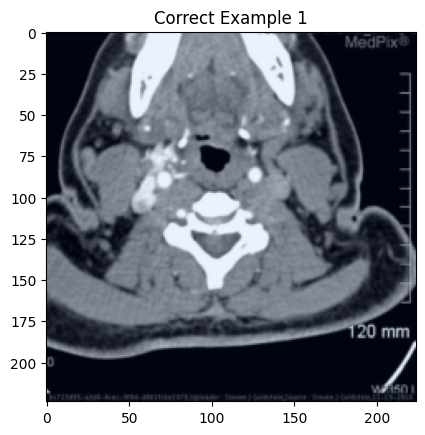

Correct Example 2:
Question: what plane is demonstrated?
True Label: coronal
Prediction: coronal


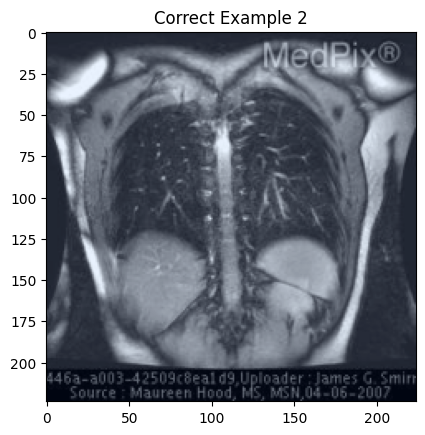

Correct Example 3:
Question: in what plane was this image taken?
True Label: axial
Prediction: axial


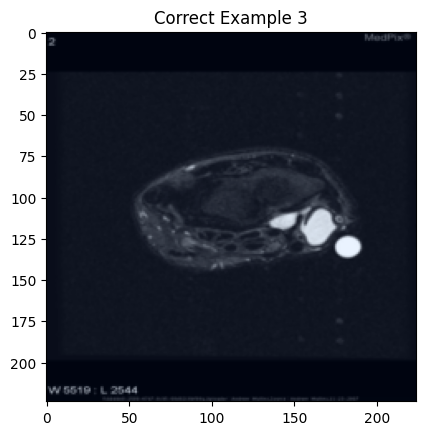

Incorrect Example 1:
Question: what plane is this x - ray in?
True Label: ap
Prediction: pa


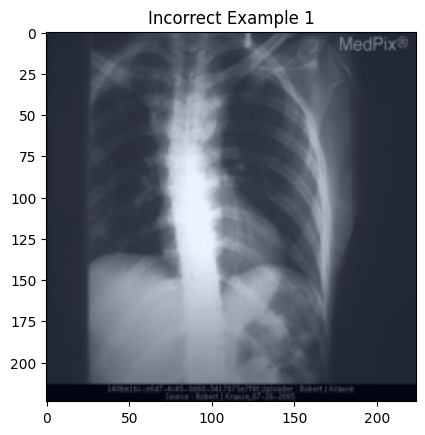

Incorrect Example 2:
Question: what imaging plane is depicted here?
True Label: frontal
Prediction: ap


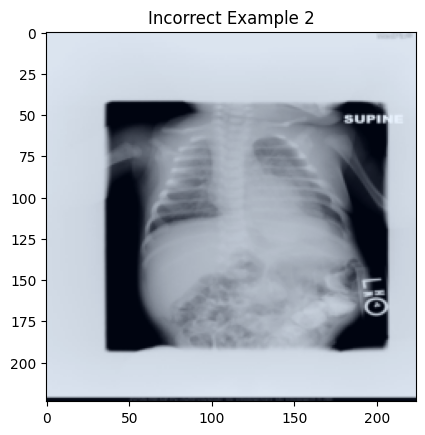

Incorrect Example 3:
Question: which plane is the image shown in?
True Label: pa
Prediction: axial


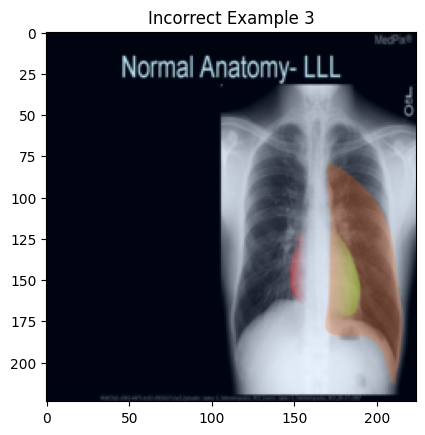

In [27]:
# Function to get multiple examples
def get_examples(model, data_loader, device, num_examples=3):
    correct_examples = []
    incorrect_examples = []

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for images, input_ids, attention_mask, answers in data_loader:
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            answers = answers.to(device)

            outputs = model(images, input_ids, attention_mask)
            _, preds = torch.max(outputs, 1)

            for i in range(len(preds)):
                if preds[i] == answers[i] and len(correct_examples) < num_examples:
                    correct_examples.append({
                        'image': images[i].cpu(),
                        'input_id': input_ids[i].cpu(),
                        'attention_mask': attention_mask[i].cpu(),
                        'true_label': answers[i].cpu(),
                        'prediction': preds[i].cpu()
                    })
                if preds[i] != answers[i] and len(incorrect_examples) < num_examples:
                    incorrect_examples.append({
                        'image': images[i].cpu(),
                        'input_id': input_ids[i].cpu(),
                        'attention_mask': attention_mask[i].cpu(),
                        'true_label': answers[i].cpu(),
                        'prediction': preds[i].cpu()
                    })

                if len(correct_examples) >= num_examples and len(incorrect_examples) >= num_examples:
                    return correct_examples, incorrect_examples

    return correct_examples, incorrect_examples

# Example usage with a validation or test DataLoader
# Ensure that you have a DataLoader named val_loader or test_loader

correct_examples, incorrect_examples = get_examples(model, valid_loader, device)

# Helper function to decode input IDs to text
def decode_input_ids(input_ids, tokenizer):
    return tokenizer.decode(input_ids, skip_special_tokens=True)

# Helper function to convert tensor image to PIL image
def tensor_to_image(tensor):
    tensor = tensor.permute(1, 2, 0)  # C x H x W -> H x W x C
    tensor = tensor.numpy()  # Convert to numpy
    tensor = (tensor * 255).astype(np.uint8)  # Denormalize if necessary
    return Image.fromarray(tensor)

# Helper function to normalize image for display
def normalize_image(tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return tensor

# Print the examples
def print_examples(examples, example_type, tokenizer):
    if examples:
        for idx, example in enumerate(examples):
            print(f"{example_type} Example {idx + 1}:")
            img = tensor_to_image(normalize_image(example['image']))
            question_text = decode_input_ids(example['input_id'], tokenizer)
            true_label = example['true_label'].item()
            prediction = example['prediction'].item()

            print("Question:", question_text)
            print("True Label:", index_to_answer[true_label])
            print("Prediction:", index_to_answer[prediction])

            plt.imshow(img)
            plt.title(f"{example_type} Example {idx + 1}")
            plt.show()
    else:
        print(f"No {example_type.lower()} examples found.")

print_examples(correct_examples, "Correct", tokenizer)
print_examples(incorrect_examples, "Incorrect", tokenizer)